In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import torch.nn as nn
import numpy as np
from torchvision import models
import matplotlib.pyplot as plt

Tensor = torch.Tensor
rand_m = np.random.random

In [2]:
class model_resnet(nn.Module):
    def __init__(self, num_class):
        super(model_resnet, self).__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        self.argp = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.Linear(512, num_class))
    
    def forward(self, x):
        x = self.resnet101.conv1(x)
        x = self.resnet101.bn1(x)
        x = self.resnet101.relu(x)
        x = self.resnet101.maxpool(x)
        x = self.resnet101.layer1(x)
        x = self.resnet101.layer2(x)
        x = self.resnet101.layer3(x)
        x = self.resnet101.layer4(x)
        x = self.argp(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
resnet = model_resnet(6).to('cuda')

In [4]:
optim = torch.optim.Adam(resnet.parameters())
loss_func = torch.nn.CrossEntropyLoss()

In [5]:
from data import data_reader
class args:
    bs = 64
    path = 'train2000/'

In [6]:
dr = data_reader(args, 'train2000/train2000.csv')

In [7]:
train_loader, test_loader = dr.get_train_loader()

In [8]:
train_loss_rec = []
train_acc_rec = []
test_loss_rec = []
test_acc_rec = []
best_acc = 0
for epoch in range(50):
    epoch_loss = 0
    total, correct = 0, 0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
        optim.zero_grad()
        y_hat = resnet(X_train)
        loss = loss_func(y_hat, torch.max(y_train, 1)[1])
        loss.backward()
        _, pred = torch.max(y_hat.data, 1)
        optim.step()
        correct += (pred == torch.max(y_train, 1)[1]).sum().item()
        total += X_train.size(0)
        epoch_loss += loss.item() / len(train_loader)
        print('\rEpoch {} | Batch # {} Train Loss {:.5f} '.format(epoch, batch_idx, loss.item()))
    print('\rEpoch {} | Epoch Train Loss {:.5f}'.format(epoch, epoch_loss))
    epoch_acc = correct / total * 100
    print('\nEpoch {} | Epoch Train Acc {:.3f}%'.format(epoch, epoch_acc))
    train_loss_rec.append(epoch_loss)
    train_acc_rec.append(epoch_acc)
    with torch.no_grad():
        test_epoch_loss = 0
        test_total = 0
        test_correct = 0
            
        for batch_idx, (X_val, y_val) in enumerate(test_loader):
            X_val, y_val = X_val.to('cuda'), y_val.to('cuda')
            
            y_hat = resnet(X_val)
            loss = loss_func(y_hat, torch.max(y_val, 1)[1])
            _, pred = torch.max(y_hat.data, 1)
                
            test_total += y_val.size(0)
            test_correct += (pred == torch.max(y_val, 1)[1]).sum().item()
            test_epoch_loss += loss.item() / len(test_loader)
             
        test_epoch_acc = test_correct / test_total * 100
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            torch.save(resnet.state_dict(), 'weights/resnet101/best_params_acc{}.pth'.format(best_acc)) 
        print('Epoch {} | Epoch Val Loss {:.5f}'.format(epoch, test_epoch_loss))
        print('Epoch {} | Epoch Val Acc {:.3f}%'.format(epoch, test_epoch_acc))
            
        test_loss_rec.append(test_epoch_loss)
        test_acc_rec.append(test_epoch_acc)

Epoch 0 | Batch # 0 Train Loss 1.80323 
Epoch 0 | Batch # 1 Train Loss 1.45510 
Epoch 0 | Batch # 2 Train Loss 1.45511 
Epoch 0 | Batch # 3 Train Loss 0.91417 
Epoch 0 | Batch # 4 Train Loss 0.95368 
Epoch 0 | Batch # 5 Train Loss 0.79836 
Epoch 0 | Batch # 6 Train Loss 0.79631 
Epoch 0 | Batch # 7 Train Loss 0.79227 
Epoch 0 | Batch # 8 Train Loss 1.04239 
Epoch 0 | Batch # 9 Train Loss 0.56203 
Epoch 0 | Batch # 10 Train Loss 0.47204 
Epoch 0 | Batch # 11 Train Loss 0.50978 
Epoch 0 | Batch # 12 Train Loss 0.49665 
Epoch 0 | Batch # 13 Train Loss 0.75149 
Epoch 0 | Batch # 14 Train Loss 0.58463 
Epoch 0 | Batch # 15 Train Loss 0.66537 
Epoch 0 | Batch # 16 Train Loss 0.34223 
Epoch 0 | Batch # 17 Train Loss 0.57700 
Epoch 0 | Batch # 18 Train Loss 0.68830 
Epoch 0 | Batch # 19 Train Loss 0.35097 
Epoch 0 | Batch # 20 Train Loss 0.78751 
Epoch 0 | Batch # 21 Train Loss 0.45081 
Epoch 0 | Batch # 22 Train Loss 0.87114 
Epoch 0 | Batch # 23 Train Loss 0.46429 
Epoch 0 | Batch # 24 Train

Process Process-69:
KeyboardInterrupt
Traceback (most recent call last):
  File "/data/tennant/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/data/tennant/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/data/tennant/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/tennant/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/tennant/data-competitions/dianshi_TG/data.py", line 39, in __getitem__
    img = self._im_read(self.img_path + self.X_train[index] + self.img_ext)
  File "/data/tennant/data-competitions/dianshi_TG/data.py", line 36, in _im_read
    return img.conver

KeyboardInterrupt: 

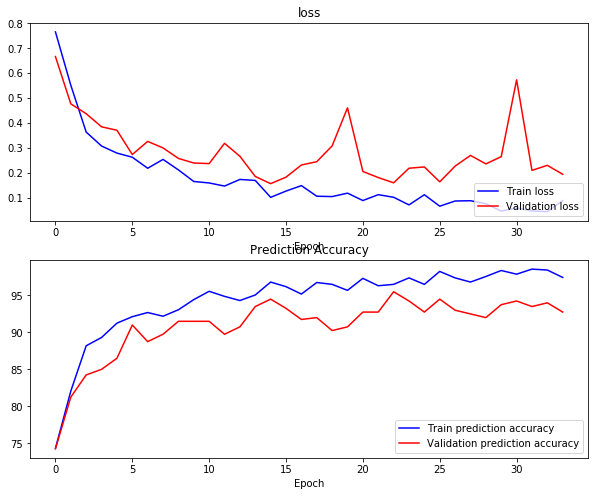

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(train_loss_rec, 'b')
plt.plot(test_loss_rec, 'r')

plt.title('loss')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_acc_rec, 'b')
plt.plot(test_acc_rec, 'r')

plt.title('Prediction Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()